In [34]:
import time
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [35]:
# Set up environment
import ale_py

gym.register_envs(ale_py)  # unnecessary but helpful for IDEs
env_name = 'Pong-v4'  # Updated to v4 to avoid deprecation warning
env = gym.make(env_name, render_mode='rgb_array')

# Frame stacking configuration
FRAME_STACK = 4  # Number of frames to stack
state_size = (84, 84, FRAME_STACK)  # Multiple frames for motion understanding
action_size = env.action_space.n
buffer_size = 100000
batch_size = 64
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for epsilon

In [36]:
def frame_preprocessing(observation_frame):
    # Crop the frame.
    observation_frame = observation_frame[35:195]
    # Downsample the frame by a factor of 2.
    observation_frame = observation_frame[::2, ::2, 0]
    # Remove the background and apply other enhancements.
    observation_frame[observation_frame == 144] = 0  # Erase the background (type 1).
    observation_frame[observation_frame == 109] = 0  # Erase the background (type 2).
    observation_frame[observation_frame != 0] = 1  # Set the items (rackets, ball) to 1.
    # Return the preprocessed frame as a 1D floating-point array.
    return observation_frame.astype(float)

In [37]:
class FrameStack:
    """
    Stack multiple frames to give the agent information about motion and velocity.
    """
    def __init__(self, num_frames=4):
        self.num_frames = num_frames
        self.frames = collections.deque(maxlen=num_frames)
        
    def reset(self, frame):
        """Reset with initial frame repeated num_frames times."""
        processed_frame = preprocess_frame(frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return self.get_stacked()
    
    def step(self, frame):
        """Add new frame and return stacked frames."""
        processed_frame = preprocess_frame(frame)
        self.frames.append(processed_frame)
        return self.get_stacked()
    
    def get_stacked(self):
        """Return stacked frames as numpy array with shape (84, 84, num_frames)."""
        return np.stack(list(self.frames), axis=2)

In [38]:
# Preprocess frame using only numpy (no external dependencies)
def preprocess_frame(frame):
    """
    Convert frame to grayscale, crop, resize to 84x84, and normalize.
    Returns a (84, 84) numpy array with values in [0, 1].
    """
    # Convert to grayscale
    frame = np.mean(frame, axis=2).astype(np.uint8)
    
    # Crop the screen to focus on the playing area (remove score and borders)
    frame = frame[34:194]  # Height: 210 -> 160
    
    # Simple downsampling to 84x84 using numpy (every 2nd pixel)
    # From 160x160 to 80x80, then pad to 84x84
    step_h = frame.shape[0] // 80  # ~2
    step_w = frame.shape[1] // 80  # ~2
    frame_small = frame[::step_h, ::step_w]
    
    # Pad to exact 84x84 if needed
    if frame_small.shape[0] < 84 or frame_small.shape[1] < 84:
        pad_h = max(0, 84 - frame_small.shape[0])
        pad_w = max(0, 84 - frame_small.shape[1])
        frame_small = np.pad(frame_small, ((0, pad_h), (0, pad_w)), mode='edge')
    
    # Crop to exact 84x84
    frame_small = frame_small[:84, :84]
    
    # Normalize pixel values to [0, 1]
    frame_small = frame_small.astype(np.float32) / 255.0
    
    return frame_small

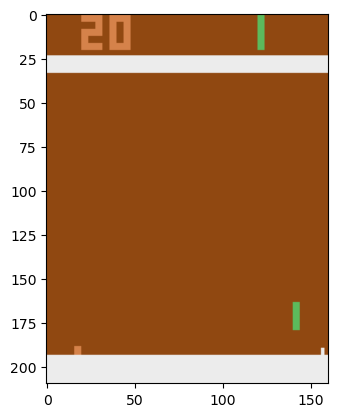

In [39]:
# play the game using a random policy and render the frames in the notebook
obs, info = env.reset() 
obs = preprocess_frame(obs)
done = False
total_reward = 0
    
while not done:
    action = env.action_space.sample()  # Random action
    obs, reward, terminated, truncated, info = env.step(action)
    plt.imshow(obs) 
    plt.show()
    clear_output(wait=True)
    obs = preprocess_frame(obs)
    total_reward += reward
        
    if terminated or truncated:
        done = True
            
time.sleep(1)

env.close() 



In [40]:
# play the game with the UI using a random policy 
def play_random_policy(env, num_episodes=10):
    for episode in range(num_episodes):
        obs, _ = env.reset()
        terminated = False
        truncated = False
        total_reward = 0
        while not (terminated or truncated):
            action = env.action_space.sample()  # Random action
            obs, reward, terminated, truncated, _ = env.step(action)  # Fixed: use terminated/truncated
            total_reward += reward
        print(f"Episode {episode + 1}: Total reward = {total_reward}")

play_random_policy(env, num_episodes=3)

Episode 1: Total reward = -21.0
Episode 2: Total reward = -20.0
Episode 3: Total reward = -19.0


In [41]:
# Build neural network model
class DQN(nn.Module):
    def __init__(self, input_shape, action_size, num_frames=4):
        super(DQN, self).__init__()
        self.input_shape = input_shape  # Expected: (batch_size, channels, height, width)
        self.num_frames = num_frames
        
        # Convolutional layers - designed for (num_frames, 84, 84) input
        self.conv_layers = nn.Sequential(
            nn.Conv2d(num_frames, 32, kernel_size=8, stride=4),  # (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # (64, 7, 7)
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate the output size of conv layers
        self.conv_output_size = self._get_conv_output()
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.conv_output_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )
    
    def _get_conv_output(self):
        """
        Helper method to get the output size of the convolutional layers.
        """
        # Create dummy input with shape (batch_size=1, channels=num_frames, height=84, width=84)
        dummy_input = torch.randn(1, self.num_frames, 84, 84)
        output = self.conv_layers(dummy_input)
        return output.size(1)
    
    def forward(self, x):
        """
        Forward pass of the network.
        Input: (batch_size, 84, 84, num_frames) - stacked frames
        Returns Q-values for each action.
        """
        # Convert from (batch_size, 84, 84, num_frames) to (batch_size, num_frames, 84, 84)
        if len(x.shape) == 4 and x.shape[-1] == self.num_frames:
            x = x.permute(0, 3, 1, 2)
        elif len(x.shape) == 3 and x.shape[-1] == self.num_frames:
            # Single sample: (84, 84, num_frames) -> (1, num_frames, 84, 84)
            x = x.permute(2, 0, 1).unsqueeze(0)
        
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [42]:
obs, _ = env.reset()
print("Original obs shape:", obs.shape)

# Test frame stacking
frame_stack = FrameStack(FRAME_STACK)
stacked_state = frame_stack.reset(obs)
print("Stacked state shape:", stacked_state.shape)

# Create tensor with correct shape for frame stacking
state_tensor = torch.tensor(np.array([stacked_state]), dtype=torch.float32)
print("State tensor shape:", state_tensor.shape)

action_size = env.action_space.n
# Use correct parameters for frame stacking
model = DQN((FRAME_STACK, 84, 84), action_size, num_frames=FRAME_STACK).float()
q_values = model(state_tensor)
print("Q-values shape:", q_values.shape)

action = 0
new_obs, reward, terminated, truncated, info = env.step(action)
print("Step info:", info)

Original obs shape: (210, 160, 3)
Stacked state shape: (84, 84, 4)
State tensor shape: torch.Size([1, 84, 84, 4])
Q-values shape: torch.Size([1, 6])
Step info: {'lives': 0, 'episode_frame_number': 3, 'frame_number': 15163}


In [43]:
env.observation_space.shape, state_tensor.shape

((210, 160, 3), torch.Size([1, 84, 84, 4]))

In [44]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])


class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

In [45]:
GAMMA = 0.99
class Agent:
    def __init__(self, env, exp_buffer, num_frames=4):
        self.env = env
        self.exp_buffer = exp_buffer
        self.frame_stack = FrameStack(num_frames)
        self._reset()

    def _reset(self):
        obs, info = self.env.reset()
        self.state = self.frame_stack.reset(obs)
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a, dtype=torch.float32).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_obs, reward, is_done, _, _ = self.env.step(action)
        new_state = self.frame_stack.step(new_obs)
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device="cpu"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states, dtype=torch.float32).to(device)
    next_states_v = torch.tensor(next_states, dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions, dtype=torch.long).to(device)
    rewards_v = torch.tensor(rewards, dtype=torch.float32).to(device)
    done_mask = torch.tensor(dones, dtype=torch.bool).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = tgt_net(next_states_v).max(1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [46]:
def play_policy(env, net, device, sleep_time=0.05):
    obs, info = env.reset() 
    frame_stack = FrameStack(FRAME_STACK)  # Create frame stack for policy playing
    state = frame_stack.reset(obs)
    terminated = False
    truncated = False
    total_reward = 0
        
    while not (terminated or truncated):
        state_a = np.array([state], copy=False)
        state_v = torch.tensor(state_a, dtype=torch.float32).to(device)
        q_vals_v = net(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())
        
        # do step in the environment
        obs, reward, terminated, truncated, info = env.step(action)
        state = frame_stack.step(obs)  # Update frame stack
        plt.imshow(obs) 
        plt.show()
        clear_output(wait=True)
        total_reward += reward
                
        time.sleep(sleep_time)
    env.close() 
    return total_reward

In [47]:
MEAN_REWARD_BOUND = 19.5

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 50000
LEARNING_RATE = 1e-4  # Reduced from 1e-2 for more stable training
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 10**6
EPSILON_START = 1.0
EPSILON_FINAL = 0.02

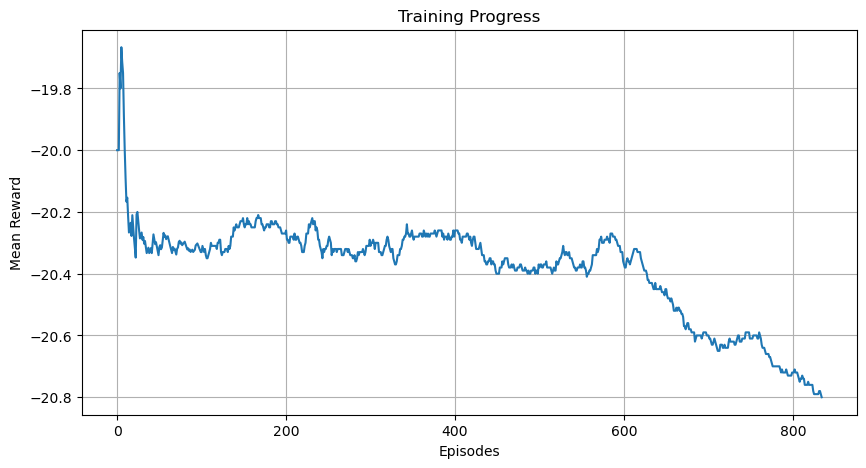

Training completed!


In [48]:
# Training loop setup
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize networks and optimizer with correct input shape for frame stacking
net = DQN((FRAME_STACK, 84, 84), env.action_space.n, num_frames=FRAME_STACK).to(device)
tgt_net = DQN((FRAME_STACK, 84, 84), env.action_space.n, num_frames=FRAME_STACK).to(device)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# Initialize buffers and tracking variables
buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer, num_frames=FRAME_STACK)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_mean_reward = None
reward_history = []

# Set maximum training frames to prevent infinite loop in notebook
MAX_FRAMES = 1000000

while frame_idx < MAX_FRAMES:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
    reward = agent.play_step(net, epsilon, device=device)
    
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        mean_reward = np.mean(total_rewards[-100:])
        reward_history.append(mean_reward)
        
        # Print progress every 10 episodes to reduce output
        if len(total_rewards) % 10 == 0:
            print(f"Frame {frame_idx}: games={len(total_rewards)}, "
                  f"mean reward={mean_reward:.3f}, eps={epsilon:.2f}, "
                  f"speed={speed:.2f} f/s")
        
        # Check for best reward
        if best_mean_reward is None or best_mean_reward < mean_reward:
            if best_mean_reward is not None:
                print(f"Best mean reward updated {best_mean_reward:.3f} -> {mean_reward:.3f}")
            best_mean_reward = mean_reward
            
        # Check if solved
        if mean_reward > MEAN_REWARD_BOUND:
            print(f"Solved in {frame_idx} frames!")
            break

    # Skip until we have enough data
    if len(buffer) < REPLAY_START_SIZE:
        continue

    # Periodic target network update and visualization
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())
        
        # Update plot
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(reward_history)
        plt.title('Training Progress')
        plt.xlabel('Episodes')
        plt.ylabel('Mean Reward')
        plt.grid(True)
        plt.show()
    
    # Training step
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss_t.backward()
    optimizer.step()

print("Training completed!")
env.close()